In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

In [2]:
os.getcwd()

'/home/ubuntu/Desktop/artwork-classifier-app/model'

In [3]:
print(tf.__version__)

2.3.0


In [4]:
# Making sure the GPU is identified by Tensorflow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Creating a training and test set from the images

# Directory where the data is stored
data_dir = "../../train"

# Defining parameters of the image loader
batch_size = 64
# img_height = 480
# img_width = 640
img_size = (256, 256)

# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# train_dir = os.path.join(PATH, 'train')
# validation_dir = os.path.join(PATH, 'validation')

# Creating the data loader for the training set
train_data = image_dataset_from_directory(
    directory=data_dir,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=102,
    batch_size=batch_size,
    image_size=img_size
)

# Creating the data loader for the validation set
validation_data = image_dataset_from_directory(
    directory=data_dir,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=102,
    batch_size=batch_size,
    image_size=img_size
)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


In [6]:
# Creating a test set from the validation set, 20% of the validation set batches

val_batches = tf.data.experimental.cardinality(validation_data)

test_data = validation_data.take(val_batches // 5)
validation_data = validation_data.skip(val_batches // 5)

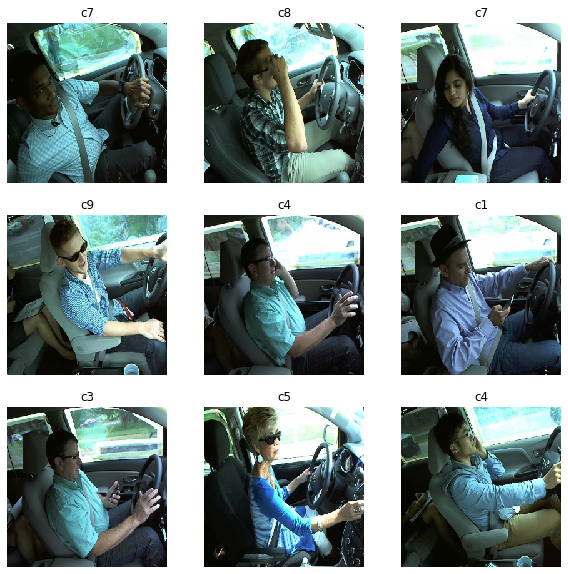

In [7]:
# Visualizing the first 9 images of the training set

class_names = train_data.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
train_data.class_names

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [9]:
# Caching and prefetching the data for better performance

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
#Implementing image augmentation layer to reduce overfitting

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
# ])

In [11]:
# Viewing the augmented data

# for image, _ in train_data.take(2):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [12]:
# Getting the preprocessing function for the ResNet50V2 model in order to preprocess the data so that it can be inputted to the ResNet50 model
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [13]:
# Creating the base model from the pre-trained model ResNet50V2

IMG_SHAPE = img_size + (3,)
print(IMG_SHAPE)

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

(256, 256, 3)


In [14]:
# Freezing the model so none of the weights of the base layers are updated during training
base_model.trainable = False

In [15]:
# Viewing the architecture of the base model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [16]:
# Feature extraction which converts each image to a 8x8x2048 block of features
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 8, 8, 2048)


In [17]:
# Converting the 5x5x2048 feature blocks to a vector of size 2048
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [18]:
# Adding a dense layer in order to get a prediction
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 10)


In [19]:
# Creating a model by chaining together all the above steps
inputs = tf.keras.Input(shape=(256, 256, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
# Compiling the model before training
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [22]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
# Training the model

initial_epochs = 15
loss0, accuracy0= model.evaluate(validation_data)

57/57 [==============================] - 26s 454ms/step - loss: 2.7877 - accuracy: 0.0892


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.79
initial accuracy: 0.09


In [25]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)

Epoch 1/15
281/281 [==============================] - 156s 556ms/step - loss: 2.1448 - accuracy: 0.2523 - val_loss: 1.6296 - val_accuracy: 0.5234
Epoch 2/15
281/281 [==============================] - 156s 555ms/step - loss: 1.5137 - accuracy: 0.5149 - val_loss: 1.2146 - val_accuracy: 0.7193
Epoch 3/15
281/281 [==============================] - 156s 556ms/step - loss: 1.1883 - accuracy: 0.6527 - val_loss: 0.9741 - val_accuracy: 0.7912
Epoch 4/15
281/281 [==============================] - 156s 555ms/step - loss: 0.9795 - accuracy: 0.7316 - val_loss: 0.8182 - val_accuracy: 0.8308
Epoch 5/15
281/281 [==============================] - 156s 555ms/step - loss: 0.8366 - accuracy: 0.7856 - val_loss: 0.7089 - val_accuracy: 0.8554
Epoch 6/15
281/281 [==============================] - 156s 555ms/step - loss: 0.7315 - accuracy: 0.8161 - val_loss: 0.6244 - val_accuracy: 0.8751
Epoch 7/15
281/281 [==============================] - 156s 556ms/step - loss: 0.6550 - accuracy: 0.8414 - val_loss: 0.5603 -

[2.1448097229003906, 1.5136538743972778, 1.1883105039596558, 0.9795397520065308, 0.8366098403930664, 0.7315317988395691, 0.6550413966178894, 0.5897562503814697, 0.5425355434417725, 0.499610960483551, 0.46542859077453613, 0.4345329701900482, 0.40835443139076233, 0.38188436627388, 0.3619396686553955]


Text(0.5, 1.0, 'Training and Validation Accuracy')

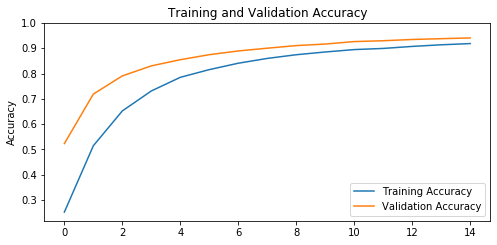

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

Text(0.5, 0, 'epoch')

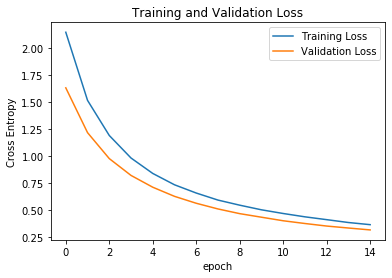

In [27]:

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [28]:
# Fine tuning the model in order to improve accuracy

# Unfreezing the base model so that the top layers can be re-trained
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [29]:
# Fine-tuning will occur from this layer onwards
fine_tune_at = 130

# Freezing all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [32]:
len(model.trainable_variables)

56

In [33]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [34]:
# Creating a callback that saves the model's weights

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [35]:
# Continuing training the model with fine-tuning

fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data,
                         callbacks=[cp_callback])

Epoch 15/18
281/281 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9680
Epoch 00015: saving model to training_1/cp.ckpt
281/281 [==============================] - 231s 821ms/step - loss: 0.1157 - accuracy: 0.9680 - val_loss: 0.0665 - val_accuracy: 0.9819
Epoch 16/18
281/281 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9953
Epoch 00016: saving model to training_1/cp.ckpt
281/281 [==============================] - 231s 822ms/step - loss: 0.0189 - accuracy: 0.9953 - val_loss: 0.0459 - val_accuracy: 0.9886
Epoch 17/18
281/281 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9984
Epoch 00017: saving model to training_1/cp.ckpt
281/281 [==============================] - 231s 823ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0363 - val_accuracy: 0.9922
Epoch 18/18
281/281 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 00018: saving model to training_1/cp.ckpt
281/281 [======

In [36]:
# Appending the fine tuning metrics to the frozen training metrics

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

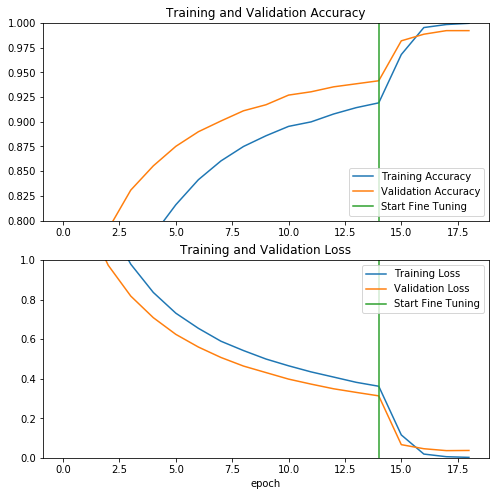

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
# Evaluating the performance of the model on the test set
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

14/14 [==============================] - 6s 425ms/step - loss: 0.0125 - accuracy: 0.9955
Test accuracy : 0.9955357313156128


In [39]:
# Making sure that the saved checkpoints can be used to reconstruct a model for inference

# Creating a fresh model with the same architecture as the trained model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
new_model = tf.keras.Model(inputs, outputs)

In [41]:
# Loading the saved weights from the trained model to the untrained model
new_model.load_weights(checkpoint_path)

In [43]:
# Compiling the new model
new_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                  metrics=['accuracy'])

In [44]:
# Re-evaluating the new model
loss,acc = new_model.evaluate(test_data)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

14/14 [==============================] - 6s 424ms/step - loss: 0.0125 - accuracy: 0.9955
Restored model, accuracy: 99.55%
